<a href="https://colab.research.google.com/github/Edward1304/Signals-Theory-Edward/blob/main/CNN_Prediction_and_detection_(labeled_signals).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Neuronal Convolucional para  prediccion y deteccion de Señales


# Edward Fabian Goyeneche Velandia.

# Teoria de Señales

In [2]:
import os
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import librosa
import zipfile
import scipy.signal as sig
from  sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler



In [3]:
import os
import librosa
import numpy as np
import scipy.signal as sig
from sklearn.preprocessing import StandardScaler

def audio_matrix(path, scaler=None):
    """
    Convierte los archivos de audio en una matriz normalizada y devuelve la frecuencia de muestreo promedio.
    
    Args:
        path (str): Ruta del directorio que contiene los archivos de audio.
        scaler (object): Escalador para normalizar los datos. Si es None, se usa StandardScaler.
    
    Returns:
        np.ndarray: Matriz de audio normalizada.
        float: Frecuencia de muestreo promedio.
    """
    if scaler is None:
        scaler = StandardScaler()
    
    fs_v = []  # Lista para almacenar las frecuencias de muestreo
    audio_m = []  # Lista para almacenar los audios transformados

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            y, sr = librosa.load(file_path, sr=None)
            y = librosa.to_mono(y)
            y = y.reshape(-1, 1)
            y = scaler.fit_transform(y)
            y = y.flatten()
            fs_v.append(sr)
            audio_m.append(y)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    fs = np.mean(fs_v)
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return np.array(audio_m_padded), fs

def welch_vector(X, fs, window, nperseg, nfft):
    """
    Aplica el método de Welch para calcular el espectro de densidad de potencia (PSD).
    
    Args:
        X (np.ndarray): Señal de entrada.
        fs (float): Frecuencia de muestreo.
        window (str): Tipo de ventana a aplicar.
        nperseg (int): Número de puntos por segmento.
        nfft (int): Número de puntos para la FFT.
    
    Returns:
        tuple: Frecuencias y PSD.
    """
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m, fs, window):
    """
    Construye una matriz PSD a partir de una matriz de audio y una frecuencia de muestreo.
    
    Args:
        audio_m (np.ndarray): Matriz de audio.
        fs (float): Frecuencia de muestreo.
        window (str): Tipo de ventana a aplicar.
    
    Returns:
        tuple: Frecuencias y matriz PSD.
    """
    M, N = audio_m.shape
    psd_matrix = np.zeros((M, N))
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs, window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

def audio_classif(classif, audio_m):
    """
    Clasifica audios en dos grupos según un vector de clasificación.
    
    Args:
        classif (np.ndarray): Vector de clasificación.
        audio_m (np.ndarray): Matriz de audio.
    
    Returns:
        tuple: Matrices de audio clasificadas.
    """
    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]
    return audio_one_m, audio_zero_m

def firwin_filter(signal, lowcut, highcut, numtaps, fs):
    """
    Aplica un filtro FIR a una señal.
    
    Args:
        signal (np.ndarray): Señal de entrada.
        lowcut (float): Frecuencia de corte baja.
        highcut (float): Frecuencia de corte alta.
        numtaps (int): Número de coeficientes del filtro.
        fs (float): Frecuencia de muestreo.
    
    Returns:
        np.ndarray: Señal filtrada.
    """
    filter_coeficients = sig.firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)
    return sig.lfilter(filter_coeficients, 1.0, signal)

def audio_filter(audio_m, lowcut, highcut, numtaps, fs):
    """
    Aplica un filtro FIR a una matriz de audio.
    
    Args:
        audio_m (np.ndarray): Matriz de audio.
        lowcut (float): Frecuencia de corte baja.
        highcut (float): Frecuencia de corte alta.
        numtaps (int): Número de coeficientes del filtro.
        fs (float): Frecuencia de muestreo.
    
    Returns:
        np.ndarray: Matriz de audios filtrados.
    """
    M, N = audio_m.shape
    filtered_signal_m = np.zeros((M, N))
    for i in range(M):
        filtered_signal_m[i] = firwin_filter(audio_m[i], lowcut, highcut, numtaps, fs)
    return filtered_signal_m

def snr(audio_ones, audio_zeros):
    """
    Calcula la relación señal-ruido (SNR) entre dos grupos de audios.
    
    Args:
        audio_ones (np.ndarray): Audios clasificados como señal.
        audio_zeros (np.ndarray): Audios clasificados como ruido.
    
    Returns:
        float: Relación señal-ruido en decibelios.
    """
    signal = np.mean(audio_ones, axis=0)
    noise = np.mean(audio_zeros, axis=0)
    P_signal = np.mean(signal**2)
    P_noise = np.mean(noise**2)
    return 10 * np.log10(P_signal / P_noise)

In [5]:
# Ruta del archivo ZIP en local
zip_path = 'ANEaudios-ST.zip'
output_dir = 'ANEaudios'

# Importar bibliotecas necesarias
import zipfile
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Verificar los archivos descomprimidos
print("Archivos descomprimidos:", os.listdir(output_dir))

# Ruta del subdirectorio ANEaudios (asegúrate de que el nombre del subdirectorio sea correcto)
subdir = os.path.join(output_dir, 'ANEaudios')
print("Archivos en ANEaudios:", os.listdir(subdir))

# Inicialización del escalador StandardScaler
scaler = StandardScaler()

def audios_matrix(path, scaler):
    """
    Carga y normaliza los audios en un directorio dado.
    
    Args:
        path (str): Ruta del directorio que contiene los archivos de audio.
        scaler (object): Escalador para normalizar los datos.
    
    Returns:
        np.ndarray: Matriz de audio normalizada.
        list: Lista de frecuencias de muestreo.
    """
    audio_matrices = []
    sampling_rates = []

    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)

        if os.path.isfile(file_path):
            print(f"Cargando archivo: {file_name}")

            try:
                y, sr = librosa.load(file_path, sr=None)
                y = librosa.to_mono(y)
                y = y.reshape(-1, 1)
                y_scaled = scaler.fit_transform(y).flatten()
                audio_matrices.append(y_scaled)
                sampling_rates.append(sr)
            except Exception as e:
                print(f"Error cargando {file_name}: {e}")

    # Asegura que todos los audios tengan la misma longitud mediante padding
    max_length = max(len(y) for y in audio_matrices)
    audio_matrices_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_matrices])

    return audio_matrices_padded, sampling_rates

# Carga los archivos de audio desde el subdirectorio ANEaudios
audio_m, fs = audios_matrix(subdir, scaler)

# Verificar la salida
print("Matriz de audio:", audio_m)
print("Frecuencias de muestreo:", fs)

Archivos descomprimidos: ['ANEaudios']
Archivos en ANEaudios: ['100.0_0_.wav', '100.0_1_.wav', '100.0_2_.wav', '100.0_3_.wav', '100.0_4_.wav', '100.0_5_.wav', '100.1_0_.wav', '100.1_1_.wav', '100.1_2_.wav', '100.1_3_.wav', '100.1_4_.wav', '100.1_5_.wav', '100.2_0_.wav', '100.2_1_.wav', '100.2_2_.wav', '100.2_3_.wav', '100.2_4_.wav', '100.2_5_.wav', '100.3_0_.wav', '100.3_1_.wav', '100.3_2_.wav', '100.3_3_.wav', '100.3_4_.wav', '100.3_5_.wav', '100.4_0_.wav', '100.4_1_.wav', '100.4_2_.wav', '100.4_3_.wav', '100.4_4_.wav', '100.4_5_.wav', '100.5_0_.wav', '100.5_1_.wav', '100.5_2_.wav', '100.5_3_.wav', '100.5_4_.wav', '100.5_5_.wav', '100.6_0_.wav', '100.6_1_.wav', '100.6_2_.wav', '100.6_3_.wav', '100.6_4_.wav', '100.6_5_.wav', '100.7_0_.wav', '100.7_1_.wav', '100.7_2_.wav', '100.7_3_.wav', '100.7_4_.wav', '100.7_5_.wav', '100.8_0_.wav', '100.8_1_.wav', '100.8_2_.wav', '100.8_3_.wav', '100.8_4_.wav', '100.8_5_.wav', '100.9_0_.wav', '100.9_1_.wav', '100.9_2_.wav', '100.9_3_.wav', '100.9_4_

In [8]:
df = pd.read_excel('Etiquetado_audios_ANE.xlsx')
df.head()

,audio_name,Signal Presence/ Absence
0,88.0_0_.wav,0
1,88.0_1_.wav,0
2,88.0_2_.wav,0
3,88.0_3_.wav,0
4,88.0_4_.wav,0


In [10]:


# Definir parámetros del filtro
lowcut = 30
highcut = 15000
numtaps = 301

# Aplicar filtro FIR a los audios
try:
    audio_filt = audio_filter(np.array(audio_m), lowcut, highcut, numtaps, np.mean(fs))
except Exception as e:
    print(f"Error al aplicar el filtro FIR: {e}")

# Vector de tiempo para la visualización
t = np.linspace(0, audio_filt.shape[1] / np.mean(fs), num=audio_filt.shape[1])

# Obtener las clasificaciones
# Asegúrate de que 'df' esté definido y contenga la columna 'Signal Presence/ Absence'
try:
    classif = df['Signal  Presence/ Absence'].to_numpy()
except KeyError as e:
    print(f"Error: {e}. Asegúrate de que la columna 'Signal Presence/ Absence' exista en el DataFrame.")

# Clasificar los audios en dos grupos
try:
    audio_ones, audio_zeros = audio_classif(classif, audio_filt)
    print(f"Número de audios clasificados como 1: {len(audio_ones)}")
    print(f"Número de audios clasificados como 0: {len(audio_zeros)}")
except Exception as e:
    print(f"Error al clasificar los audios: {e}")

Número de audios clasificados como 1: 535
Número de audios clasificados como 0: 669


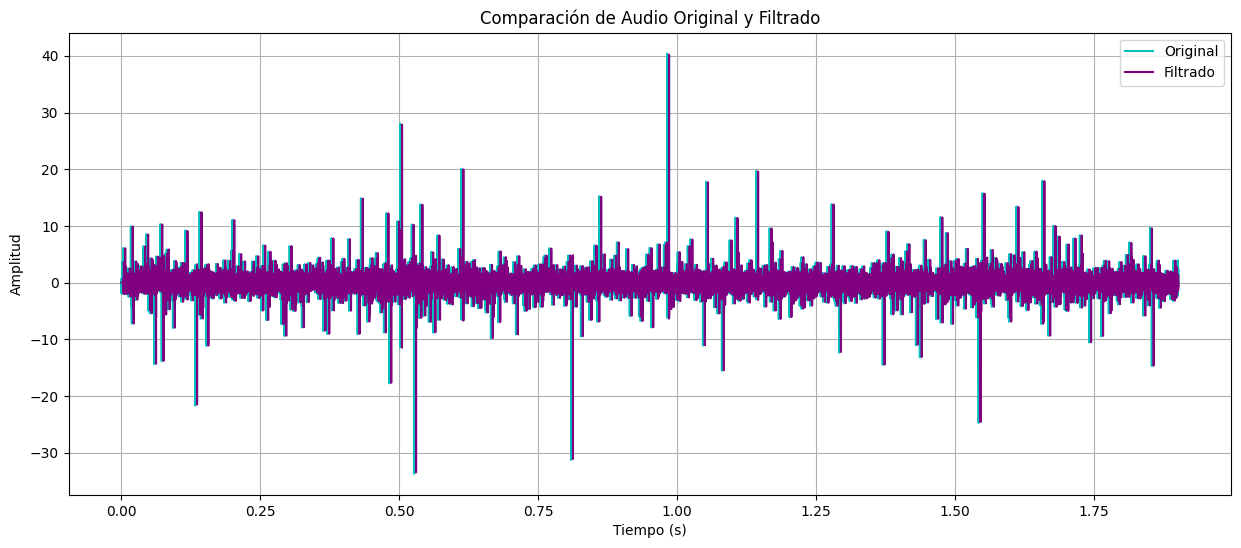

In [13]:


def plot_audio_comparison(t, original_audio, filtered_audio, index):
    """
    Plotea la comparación entre el audio original y el audio filtrado.
    
    Args:
        t (np.ndarray): Vector de tiempo.
        original_audio (np.ndarray): Matriz de audio original.
        filtered_audio (np.ndarray): Matriz de audio filtrado.
        index (int): Índice del audio a plotear.
    """
    if index >= len(original_audio) or index >= len(filtered_audio):
        print(f"Índice {index} fuera de rango.")
        return

    plt.figure(figsize=(15, 6))
    plt.plot(t, original_audio[index], label='Original', color='c')
    plt.plot(t, filtered_audio[index], label='Filtrado', color='purple')
    plt.title('Comparación de Audio Original y Filtrado')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

# Asegúrate de que 't', 'audio_m', y 'audio_filt' estén definidos y sean correctos
plot_audio_comparison(t, audio_m, audio_filt, 200)

Frecuencias para audios clasificados como 1: [0.00000000e+00 2.62858301e-01 5.25716602e-01 ... 2.20493429e+04
 2.20496057e+04 2.20498686e+04]
PSD para audios clasificados como 1: [[9.58019520e-06 2.41168575e-05 3.74384170e-05 ... 7.61973378e-18
  1.10210925e-17 6.75747407e-18]
 [8.83912708e-06 2.29332010e-05 4.10054732e-05 ... 2.15554128e-18
  2.68778908e-18 9.84100902e-18]
 [1.86735737e-05 3.67909262e-05 3.40006784e-05 ... 1.27157008e-17
  1.35056037e-17 1.32195428e-17]
 ...
 [5.28059226e-06 3.09314121e-05 7.68134344e-05 ... 8.69855017e-18
  2.36225696e-17 4.88240411e-17]
 [9.37072717e-05 1.81449790e-04 1.78011780e-04 ... 1.30046379e-18
  2.14607430e-21 1.04680185e-18]
 [7.20580357e-06 2.32485700e-05 3.08865746e-05 ... 6.54343317e-18
  5.42865723e-18 1.47221845e-18]]
PSD para audios clasificados como 0: [[1.76428713e-05 4.35626632e-05 6.57635850e-05 ... 1.79325852e-17
  2.03911827e-17 1.91435799e-17]
 [1.69034515e-04 3.29661245e-04 3.02343276e-04 ... 2.13432460e-18
  4.37802883e-19 1.

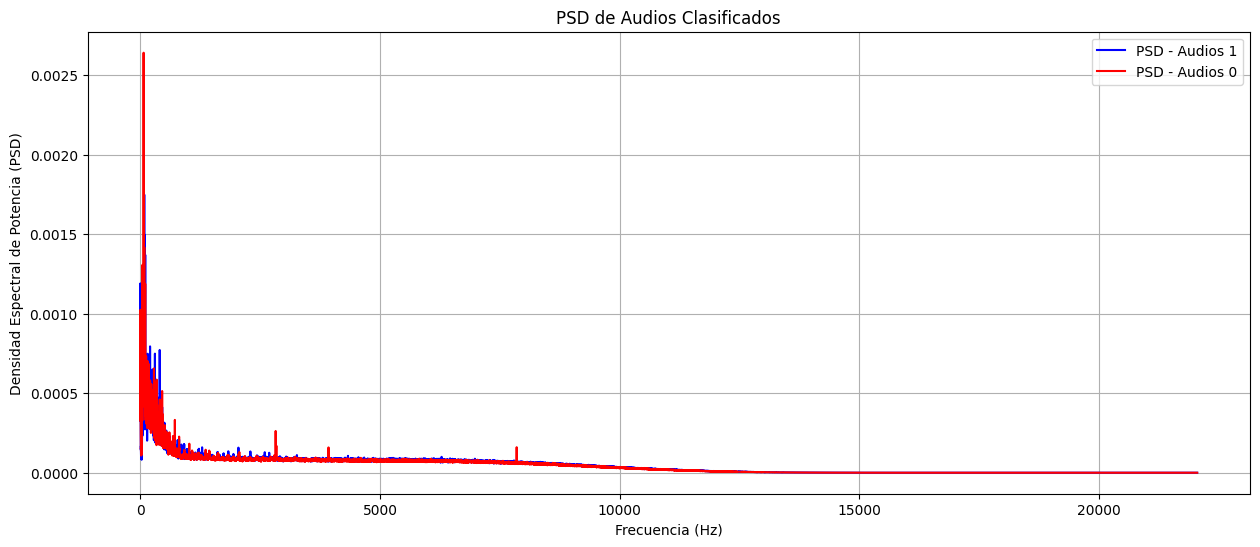

In [14]:


def calculate_and_print_psd(audio_ones, audio_zeros, fs, window):
    """
    Calcula y muestra el PSD para los audios clasificados como 1 y 0.
    
    Args:
        audio_ones (np.ndarray): Matriz de audios clasificados como 1.
        audio_zeros (np.ndarray): Matriz de audios clasificados como 0.
        fs (float): Frecuencia de muestreo.
        window (str): Tipo de ventana a aplicar.
    """
    try:
        if audio_ones.size == 0 or audio_zeros.size == 0:
            raise ValueError("Las matrices de audio no deben estar vacías.")

        f, psd_ones = psd_matrix(audio_ones, fs, window)
        f, psd_zeros = psd_matrix(audio_zeros, fs, window)

        print(f"Frecuencias para audios clasificados como 1: {f}")
        print(f"PSD para audios clasificados como 1: {psd_ones}")
        print(f"PSD para audios clasificados como 0: {psd_zeros}")

        # Visualización de los resultados
        plt.figure(figsize=(15, 6))
        plt.plot(f, np.mean(psd_ones, axis=0), label='PSD - Audios 1', color='blue')
        plt.plot(f, np.mean(psd_zeros, axis=0), label='PSD - Audios 0', color='red')
        plt.title('PSD de Audios Clasificados')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Densidad Espectral de Potencia (PSD)')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error al calcular el PSD: {e}")

# Calcular el PSD para los audios clasificados como 1 y 0
calculate_and_print_psd(audio_ones, audio_zeros, np.mean(fs), 'blackmanharris')

In [ ]:
print(f"Relación Señal-Ruido (SNR): {snr(audio_ones, audio_zeros)} dB")

# Imprime las dimensiones del array `psd_ones`, que contiene el PSD para los audios clasificados como 1
print('psd_emisora=', psd_ones.shape)

# Imprime las dimensiones del array `psd_zeros`, que contiene el PSD para los audios clasificados como 0
print('psd_ruido=', psd_zeros.shape)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18592\3013843751.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, np.max(f)])


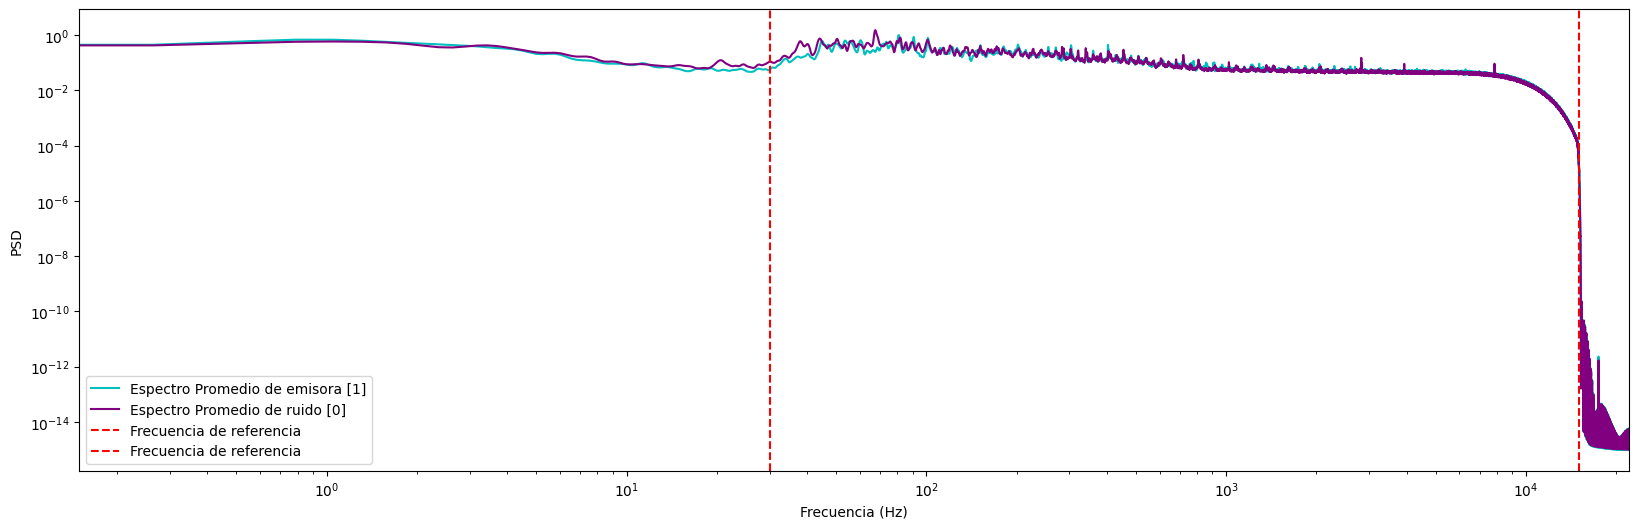

In [25]:
f, psd_ones = psd_matrix(audio_ones, np.mean(fs), 'blackmanharris')
f, psd_zeros = psd_matrix(audio_zeros, np.mean(fs), 'blackmanharris')


# Calcula el promedio del PSD a lo largo de las dimensiones de los audios clasificados como 1
psd_ones_mean = np.mean(psd_ones, axis=0)
# Calcula el promedio del PSD a lo largo de las dimensiones de los audios clasificados como 0
psd_zeros_mean = np.mean(psd_zeros, axis=0)

# Encuentra el valor máximo del PSD promedio para los audios clasificados como 1
psd_ones_max = np.max(psd_ones_mean)
# Encuentra el valor máximo del PSD promedio para los audios clasificados como 0
psd_zeros_max = np.max(psd_zeros_mean)

# Normaliza el PSD promedio de los audios clasificados como 1 dividiendo por su valor máximo
psd_ones_mean_normalized = psd_ones_mean / psd_ones_max
# Normaliza el PSD promedio de los audios clasificados como 0 dividiendo por el valor máximo de los audios clasificados como 1
psd_zeros_mean_normalized = psd_zeros_mean / psd_ones_max

# Crea una figura para la visualización del PSD
plt.figure(figsize=(20,6))
# Dibuja el PSD promedio normalizado de los audios clasificados como 1 en una escala logarítmica
plt.loglog(f, psd_ones_mean_normalized, label='Espectro Promedio de emisora [1]', color='c')
# Dibuja el PSD promedio normalizado de los audios clasificados como 0 en una escala logarítmica
plt.loglog(f, psd_zeros_mean_normalized, label='Espectro Promedio de ruido [0]', color='purple')
# Etiqueta el eje x como 'Frecuencia (Hz)'
plt.xlabel('Frecuencia (Hz)')
# Etiqueta el eje y como 'PSD'
plt.ylabel('PSD')
# Añade líneas verticales de referencia en las frecuencias de 30 Hz y 15000 Hz
plt.axvline(x=30, color='red', linestyle='--', label='Frecuencia de referencia')
plt.axvline(x=15000, color='red', linestyle='--', label='Frecuencia de referencia')
# Define el límite del eje x desde 0 hasta el valor máximo de las frecuencias
plt.xlim([0, np.max(f)])
# Muestra la leyenda del gráfico
plt.legend()
# Muestra el gráfico
plt.show()


1.0


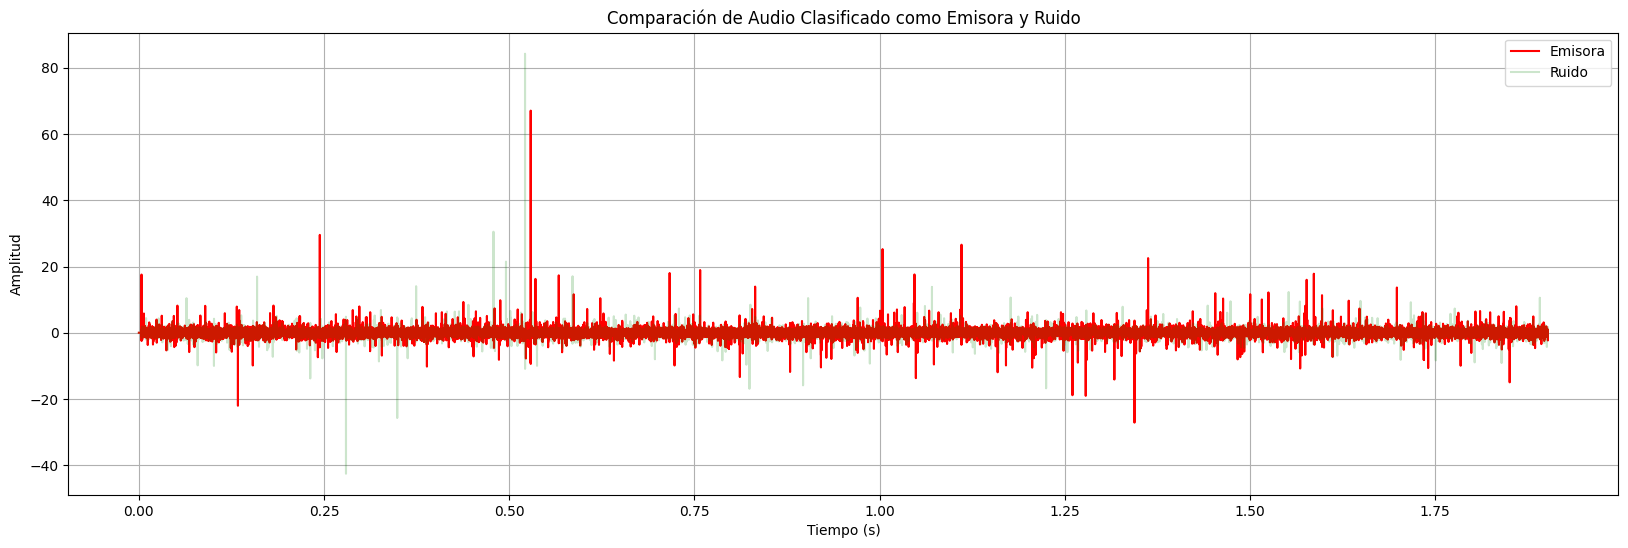

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_comparison(t, audio_ones, audio_zeros, index):
    """
    Plotea la comparación entre el audio clasificado como emisora y el audio clasificado como ruido.
    
    Args:
        t (np.ndarray): Vector de tiempo.
        audio_ones (np.ndarray): Matriz de audios clasificados como emisora.
        audio_zeros (np.ndarray): Matriz de audios clasificados como ruido.
        index (int): Índice del audio a plotear.
    """
    try:
        if index >= len(audio_ones) or index >= len(audio_zeros):
            raise IndexError(f"Índice {index} fuera de rango.")

        print(np.max(psd_ones_mean_normalized))

        plt.figure(figsize=(20, 6))
        plt.plot(t, audio_ones[index], label='Emisora', color='red')
        plt.plot(t, audio_zeros[index], label='Ruido', color='green', alpha=0.2)
        plt.title('Comparación de Audio Clasificado como Emisora y Ruido')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud')
        plt.legend()
        plt.grid(True)
        plt.show()

    except IndexError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Error inesperado: {e}")

# Asegúrate de que 't', 'audio_ones', y 'audio_zeros' estén definidos y sean correctos
plot_audio_comparison(t, audio_ones, audio_zeros, 200)

In [30]:
def calculate_snr(audio_ones, audio_zeros):
    """
    Calcula la relación señal a ruido (SNR) en decibelios (dB) para las señales de audio.
    
    Args:
        audio_ones (np.ndarray): Matriz de audios clasificados como señal.
        audio_zeros (np.ndarray): Matriz de audios clasificados como ruido.
    
    Returns:
        float: Relación señal a ruido en decibelios (dB).
    """
    try:
        if audio_ones.size == 0 or audio_zeros.size == 0:
            raise ValueError("Las matrices de audio no deben estar vacías.")

        snrdB = snr(audio_ones, audio_zeros)
        return snrdB

    except Exception as e:
        print(f"Error al calcular el SNR: {e}")
        return None

# Calcular la relación señal a ruido (SNR) en decibelios (dB) para las señales de audio
snrdB = calculate_snr(audio_ones, audio_zeros)
if snrdB is not None:
    print(f'SNR de las señales respecto al ruido es = {snrdB} dB')

SNR de las señales respecto al ruido es = 1.0700582011495499 dB


In [31]:
def calculate_normalized_power(psd_ones, psd_zeros, f, lowcut=30, highcut=15000):
    """
    Calcula la potencia normalizada para las bandas de frecuencia especificadas.
    
    Args:
        psd_ones (np.ndarray): PSD de audios clasificados como señal.
        psd_zeros (np.ndarray): PSD de audios clasificados como ruido.
        f (np.ndarray): Frecuencias correspondientes al PSD.
        lowcut (float): Frecuencia de corte baja.
        highcut (float): Frecuencia de corte alta.
    
    Returns:
        tuple: Vectores de potencia normalizada para audios clasificados como señal y ruido.
    """
    try:
        if psd_ones.size == 0 or psd_zeros.size == 0:
            raise ValueError("Las matrices de PSD no deben estar vacías.")

        # Definir banda de frecuencias
        band_mask = (f >= lowcut) & (f <= highcut)
        psd_ones_band = psd_ones[:, band_mask]
        psd_zeros_band = psd_zeros[:, band_mask]

        # Calcular la potencia normalizada para cada fila de PSD de los audios clasificados como 1
        psd_ones_max = np.max(psd_ones_band, axis=1)
        psd_ones_power_v = np.mean(psd_ones_band, axis=1) / psd_ones_max

        # Calcular la potencia normalizada para cada fila de PSD de los audios clasificados como 0
        psd_zeros_max = np.max(psd_zeros_band, axis=1)
        psd_zeros_power_v = np.mean(psd_zeros_band, axis=1) / psd_zeros_max

        return psd_ones_power_v, psd_zeros_power_v

    except Exception as e:
        print(f"Error al calcular la potencia normalizada: {e}")
        return None, None

# Calcular la potencia normalizada para las bandas de frecuencia especificadas
psd_ones_power_v, psd_zeros_power_v = calculate_normalized_power(psd_ones, psd_zeros, f)

# Verificar la salida
if psd_ones_power_v is not None and psd_zeros_power_v is not None:
    print("Potencia normalizada para audios clasificados como 1:", psd_ones_power_v)
    print("Potencia normalizada para audios clasificados como 0:", psd_zeros_power_v)

Potencia normalizada para audios clasificados como 1: [0.07738771 0.05389472 0.00965962 0.06690701 0.06436821 0.00266738
 0.07538784 0.05385259 0.07837047 0.05814539 0.00084531 0.05459356
 0.07411571 0.00242733 0.00282162 0.00080149 0.00230206 0.00996413
 0.00278517 0.00084873 0.00121473 0.00044797 0.00268624 0.00210756
 0.00051039 0.00085322 0.00109724 0.00137248 0.02448184 0.00279482
 0.00151467 0.00108031 0.01961238 0.0056337  0.00122934 0.00117642
 0.00052955 0.00120104 0.00227823 0.00392816 0.00114999 0.00060876
 0.00202741 0.00379864 0.00884499 0.00341726 0.00058616 0.00199059
 0.00042418 0.00287201 0.00530416 0.00157012 0.00621261 0.0018794
 0.00191079 0.0060555  0.01299677 0.01353629 0.08010843 0.0618035
 0.05724449 0.06851824 0.06988968 0.07131474 0.07007294 0.073425
 0.06997251 0.05756409 0.05255619 0.06298951 0.07233438 0.07739085
 0.07579704 0.06110362 0.06816232 0.05771191 0.06401229 0.07104099
 0.07088696 0.06845929 0.06535106 0.06564497 0.06506121 0.05921917
 0.06069344 

Dimensión de la matriz de Radio = (535, 349, 162)
Dimensión de la matriz de Ruido = (669, 349, 162)


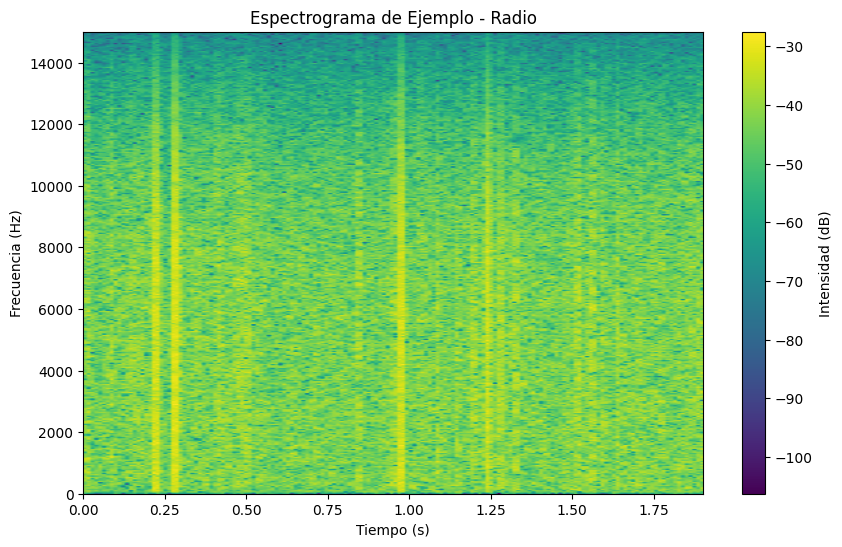

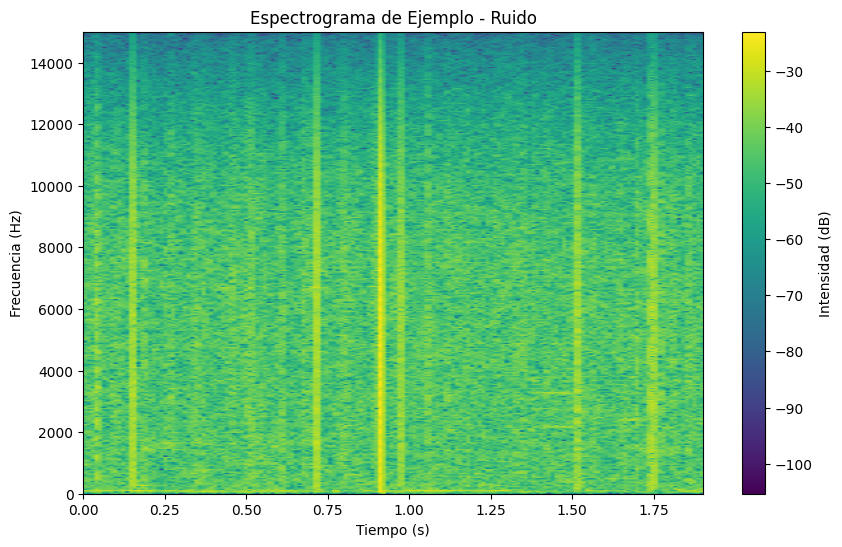

In [33]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def compute_spectrograms(audio_ones, audio_zeros, fs, max_freq=15000):
    """
    Calcula los espectrogramas para los audios clasificados como 1 (Radio) y 0 (Ruido).
    
    Args:
        audio_ones (np.ndarray): Matriz de audios clasificados como señal.
        audio_zeros (np.ndarray): Matriz de audios clasificados como ruido.
        fs (float): Frecuencia de muestreo.
        max_freq (float): Frecuencia máxima para el espectrograma.
    
    Returns:
        tuple: Espectrogramas para audios clasificados como señal y ruido.
    """
    def process_audio(audio_data):
        spectrograms = []
        for audio in audio_data:
            # Calcular el espectrograma
            f, t, Sxx = signal.spectrogram(audio.flatten(), fs, nperseg=1024, noverlap=512)

            # Limitar el rango de frecuencias
            freq_mask = f <= max_freq
            f = f[freq_mask]
            Sxx = Sxx[freq_mask]

            # Convertir a escala dB
            Sxx_db = 10 * np.log10(Sxx + np.finfo(float).eps)  # Añadir un valor pequeño para evitar log(0)

            spectrograms.append(Sxx_db)

        return np.array(spectrograms)

    try:
        if audio_ones.size == 0 or audio_zeros.size == 0:
            raise ValueError("Las matrices de audio no deben estar vacías.")

        # Calcular los espectrogramas para los audios clasificados como 1
        spectrograms_ones = process_audio(audio_ones)

        # Calcular los espectrogramas para los audios clasificados como 0
        spectrograms_zeros = process_audio(audio_zeros)

        return spectrograms_ones, spectrograms_zeros

    except Exception as e:
        print(f"Error al calcular los espectrogramas: {e}")
        return None, None

# Aplicar la función de espectrogramas a los audios filtrados y clasificados
spectrograms_ones, spectrograms_zeros = compute_spectrograms(audio_ones, audio_zeros, np.mean(fs))

# Verificar la salida
if spectrograms_ones is not None and spectrograms_zeros is not None:
    max_freq = 15000  # Define max_freq here
    print(f"Dimensión de la matriz de Radio = {spectrograms_ones.shape}")
    print(f"Dimensión de la matriz de Ruido = {spectrograms_zeros.shape}")

    # Visualización de un espectrograma de ejemplo
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrograms_ones[0], aspect='auto', origin='lower', cmap='viridis', extent=[0, t[-1], 0, max_freq])
    plt.colorbar(label='Intensidad (dB)')
    plt.title('Espectrograma de Ejemplo - Radio')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrograms_zeros[0], aspect='auto', origin='lower', cmap='viridis', extent=[0, t[-1], 0, max_freq])
    plt.colorbar(label='Intensidad (dB)')
    plt.title('Espectrograma de Ejemplo - Ruido')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    plt.show()

In [37]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner as kt

def preprocess_data(spectrograms_ones, spectrograms_zeros):
    """
    Preprocesa los datos de espectrogramas y etiquetas.
    
    Args:
        spectrograms_ones (np.ndarray): Espectrogramas clasificados como señal.
        spectrograms_zeros (np.ndarray): Espectrogramas clasificados como ruido.
    
    Returns:
        tuple: Datos de entrenamiento y prueba, y etiquetas correspondientes.
    """
    try:
        if spectrograms_ones.size == 0 or spectrograms_zeros.size == 0:
            raise ValueError("Las matrices de espectrogramas no deben estar vacías.")

        # Crear etiquetas: 1 para "Radio" y 0 para "Ruido"
        labels_ones = np.ones(len(spectrograms_ones))
        labels_zeros = np.zeros(len(spectrograms_zeros))

        # Unir los espectrogramas y las etiquetas
        X = np.concatenate((spectrograms_ones, spectrograms_zeros), axis=0)
        y = np.concatenate((labels_ones, labels_zeros), axis=0)

        # Dividir en conjunto de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=84)

        # Redimensionar los datos para que tengan el formato (num_samples, height, width, channels)
        X_train = X_train[..., np.newaxis]  # Añadir un eje para el canal
        X_test = X_test[..., np.newaxis]

        # Convertir las etiquetas a formato categórico
        y_train = tf.keras.utils.to_categorical(y_train, 2)
        y_test = tf.keras.utils.to_categorical(y_test, 2)

        return X_train, X_test, y_train, y_test

    except Exception as e:
        print(f"Error en el preprocesamiento de datos: {e}")
        return None, None, None, None

def build_model(hp):
    """
    Construye el modelo de red neuronal con hiperparámetros ajustables.
    
    Args:
        hp (kt.HyperParameters): Hiperparámetros ajustables.
    
    Returns:
        tf.keras.Model: Modelo compilado.
    """
    try:
        model = tf.keras.Sequential()

        # Capa Conv2D: el número de filtros y el tamaño del kernel serán elegidos por el tuner
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5]),
            activation='relu',
            input_shape=(X_train.shape[1], X_train.shape[2], 1)  # Ajustado para tus datos
        ))

        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

        # Segunda capa Conv2D con hiperparámetros ajustables
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu'
        ))

        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

        model.add(tf.keras.layers.Flatten())

        # Capa densa con número de unidades ajustables
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

        # Capa de salida
        model.add(tf.keras.layers.Dense(2, activation='softmax'))  # Cambiado a 2 para la clasificación

        # Compilar el modelo
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    except Exception as e:
        print(f"Error al construir el modelo: {e}")
        return None

# Preprocesar los datos
X_train, X_test, y_train, y_test = preprocess_data(spectrograms_ones, spectrograms_zeros)

if X_train is not None and X_test is not None:
    # Configurar el tuner de RandomSearch
    tuner = kt.RandomSearch(
        build_model,               # Función que construye el modelo
        objective='val_accuracy',   # Maximizar la precisión en validación
        max_trials=5,               # Número de configuraciones distintas a probar
        executions_per_trial=3,     # Número de ejecuciones por configuración (media de los resultados)
        directory='tuner_dir',      # Directorio donde guardar los resultados
        project_name='spectrogram_tuning'  # Nombre del proyecto
    )

    # Mostrar un resumen del espacio de búsqueda
    tuner.search_space_summary()

    # Añadir callbacks para mejorar el entrenamiento del modelo
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

    # Realizar la búsqueda de hiperparámetros
    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=callbacks)

    # Obtener el mejor modelo después de la búsqueda
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluar el mejor modelo
    test_loss, test_acc = best_model.evaluate(X_test, y_test)
    print(f"Mejor precisión en el conjunto de prueba: {test_acc}")

    # Mostrar los mejores hiperparámetros encontrados
    tuner.results_summary()

Trial 1 Complete [00h 25m 05s]
val_accuracy: 0.560773491859436

Best val_accuracy So Far: 0.560773491859436
Total elapsed time: 00h 25m 05s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |128               |filters
3                 |3                 |kernel_size
64                |64                |filters_2
3                 |5                 |kernel_size_2
32                |64                |units
0.00041065        |0.00058807        |learning_rate

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.5285 - loss: 14.3142 - val_accuracy: 0.4392 - val_loss: 0.6932
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.5495 - loss: 0.6931 - val_accuracy: 0.5608 - val_loss: 0.6927
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5368 - loss: 0.6928 - val_accuracy: 0.5608 - val_loss: 0.6922
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5269 - loss: 0.6926 - val_accuracy: 0.5608 - val

In [1]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def preprocess_data(spectrograms_ones, spectrograms_zeros):
    """
    Preprocesa los datos de espectrogramas y etiquetas.
    
    Args:
        spectrograms_ones (np.ndarray): Espectrogramas clasificados como señal.
        spectrograms_zeros (np.ndarray): Espectrogramas clasificados como ruido.
    
    Returns:
        tuple: Datos de entrenamiento y prueba, y etiquetas correspondientes.
    """
    try:
        if spectrograms_ones.size == 0 or spectrograms_zeros.size == 0:
            raise ValueError("Las matrices de espectrogramas no deben estar vacías.")

        # Combine spectrograms and create labels
        all_spectrograms = np.concatenate((spectrograms_ones, spectrograms_zeros), axis=0)
        labels = np.concatenate((np.ones(spectrograms_ones.shape[0]),
                                 np.zeros(spectrograms_zeros.shape[0])))

        # Reshape the data to include a channel dimension (for grayscale images)
        all_spectrograms = all_spectrograms.reshape((-1, all_spectrograms.shape[1], all_spectrograms.shape[2], 1))

        # Normalize the data
        all_spectrograms = (all_spectrograms - np.mean(all_spectrograms)) / np.std(all_spectrograms)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(all_spectrograms, labels, test_size=0.2, random_state=42)

        return X_train, X_test, y_train, y_test

    except Exception as e:
        print(f"Error en el preprocesamiento de datos: {e}")
        return None, None, None, None

def build_and_train_model(X_train, y_train, X_test, y_test):
    """
    Construye y entrena el modelo de red neuronal.
    
    Args:
        X_train (np.ndarray): Datos de entrenamiento.
        y_train (np.ndarray): Etiquetas de entrenamiento.
        X_test (np.ndarray): Datos de prueba.
        y_test (np.ndarray): Etiquetas de prueba.
    
    Returns:
        keras.Model: Modelo entrenado.
        dict: Historia del entrenamiento.
    """
    try:
        # Create the smaller model
        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # Print model summary
        model.summary()

        # Añadir callbacks para mejorar el entrenamiento del modelo
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
            keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
        ]

        # Train the model
        history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Test accuracy: {test_acc:.4f}')

        return model, history

    except Exception as e:
        print(f"Error al construir o entrenar el modelo: {e}")
        return None, None

def plot_training_history(history):
    """
    Plotea la historia de entrenamiento del modelo.
    
    Args:
        history (dict): Historia del entrenamiento.
    """
    try:
        if history is None:
            raise ValueError("La historia de entrenamiento no debe estar vacía.")

        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()

    except Exception as e:
        print(f"Error al plotear la historia de entrenamiento: {e}")

# Preprocesar los datos
X_train, X_test, y_train, y_test = preprocess_data(spectrograms_ones, spectrograms_zeros)

if X_train is not None and X_test is not None:
    # Construir y entrenar el modelo
    model, history = build_and_train_model(X_train, y_train, X_test, y_test)

    if history is not None:
        # Plotea la historia de entrenamiento
        plot_training_history(history)

NameError: name 'spectrograms_ones' is not defined